# Covid Data Preparation

In diesem Notebook werden die Daten aufbereitet.

## Imports and Files

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

PATH_COLLECTED_DATA = './collected_data.csv'

In [2]:
# define function to help remove missing values
def addNumberOfMissingValuesToDataframe(dataframe):
    missing_values = []
    for i in range(len(dataframe.index)):
        missing_values.append(dataframe.iloc[i].isnull().sum())
    dataframe['missing_values'] = missing_values
    return dataframe

(209, 55)


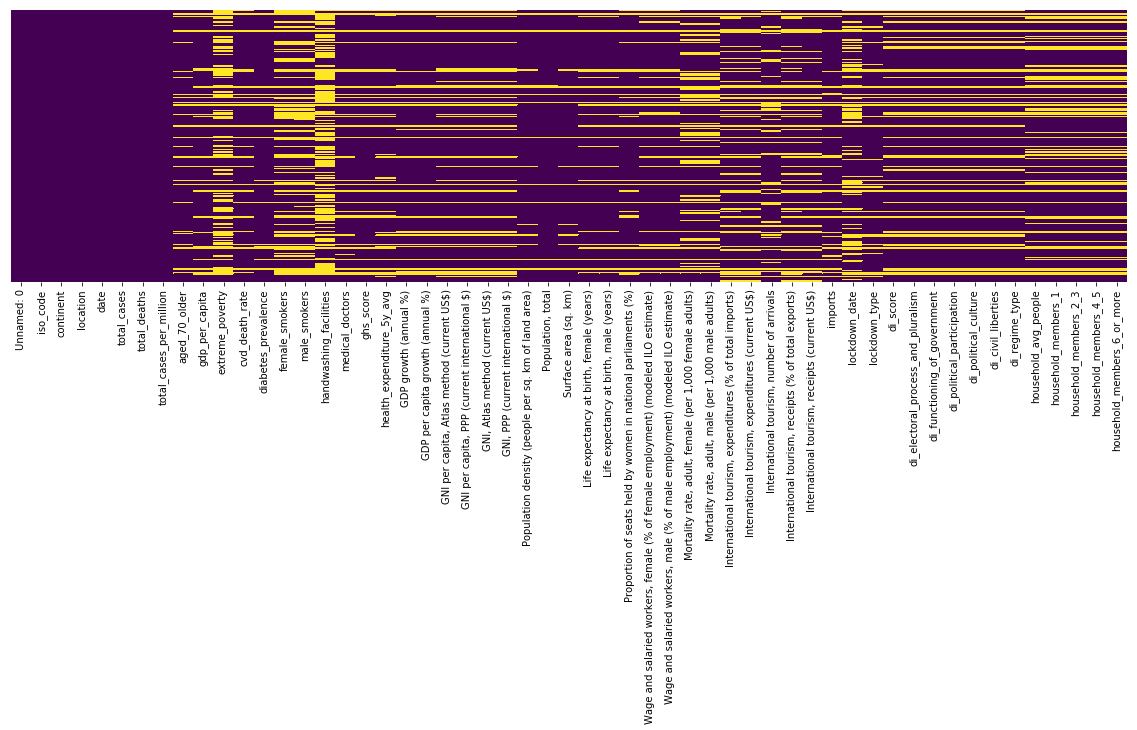

In [3]:
# read data
df = pd.read_csv(PATH_COLLECTED_DATA)
df_original = df.copy()
df.drop(['Female share of employment in senior and middle management (%)','Firms with female participation in ownership (% of firms)', 'Women who were first married by age 18 (% of women ages 20-24)', 'International tourism, number of departures', 'overweight_in_percent', 'stunting_in_percent', 'underweight_in_percent'],inplace=True, axis=1)

print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

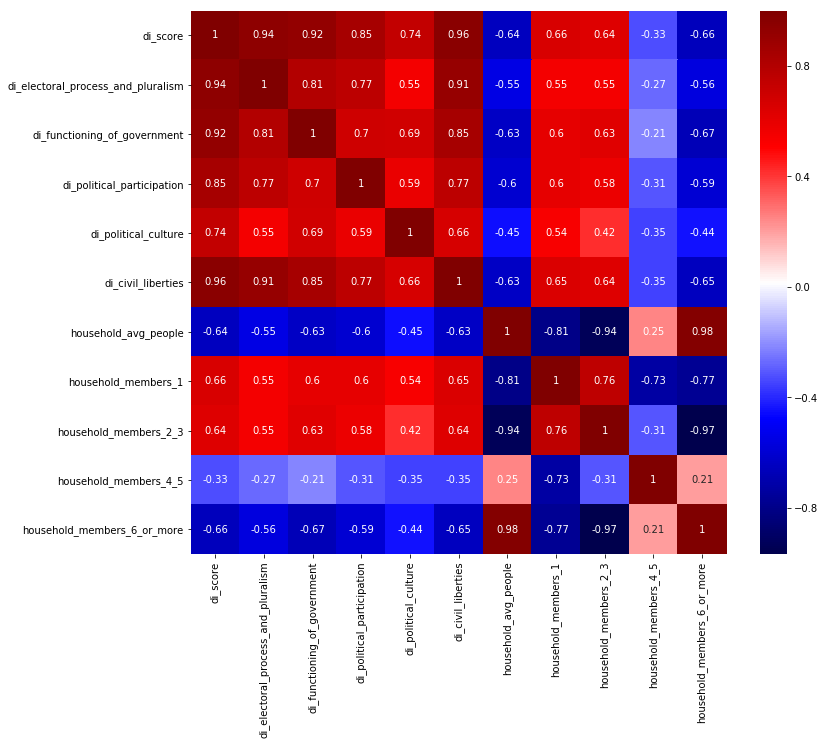

In [4]:
# correlation and removal
corr = df.loc[:, ['di_score', 'di_electoral_process_and_pluralism', 'di_functioning_of_government', 'di_political_participation', 'di_political_culture', 'di_civil_liberties', 'household_avg_people', 'household_members_1', 'household_members_2_3', 'household_members_4_5', 'household_members_6_or_more']].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="seismic")
plt.show()

In [5]:
# drop di values because of correlation
# drop household values because of correlation
df.drop(['di_electoral_process_and_pluralism', 'di_functioning_of_government', 'di_political_participation', 'di_political_culture', 'di_civil_liberties', 'di_regime_type', 'household_members_1', 'household_members_2_3', 'household_members_4_5', 'household_members_6_or_more'],inplace=True, axis=1)

corr = df.corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [6]:
# delete columns with strong correlation
df.drop(['GNI per capita, Atlas method (current US$)', 'GNI per capita, PPP (current international $)', 'GNI, PPP (current international $)', 'GDP growth (annual %)', 'handwashing_facilities', 'International tourism, expenditures (current US$)', 'International tourism, number of arrivals', 'International tourism, receipts (current US$)'], inplace=True, axis=1)

corr = df.corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Unnamed: 0,total_cases,total_deaths,total_cases_per_million,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP per capita growth (annual %),"GNI, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),"Life expectancy at birth, female (years)","Life expectancy at birth, male (years)",Proportion of seats held by women in national parliaments (%),"Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Mortality rate, adult, female (per 1,000 female adults)","Mortality rate, adult, male (per 1,000 male adults)","International tourism, expenditures (% of total imports)","International tourism, receipts (% of total exports)",imports,di_score,household_avg_people
Unnamed: 0,1,0.049,0.017,-0.0062,-0.099,-0.056,0.077,0.079,-0.0014,-0.11,0.0029,-0.087,-0.025,-0.042,-0.0042,0.018,0.021,-0.045,-0.029,-0.083,-0.14,-0.0015,0.0047,0.008,0.047,0.1,-0.17,-0.047,0.0023,-0.02,0.15
total_cases,0.049,1,0.93,0.2,0.13,0.16,-0.14,-0.11,0.046,0.11,-0.068,0.08,0.34,0.3,0.017,0.77,-0.027,0.31,0.59,0.13,0.13,-0.02,0.14,0.15,-0.13,-0.11,-0.017,-0.14,0.67,0.13,-0.15
total_deaths,0.017,0.93,1,0.17,0.22,0.18,-0.15,-0.19,0.0011,0.17,-0.11,0.11,0.41,0.38,-0.0022,0.77,-0.037,0.25,0.45,0.18,0.18,0.072,0.17,0.16,-0.12,-0.09,-0.042,-0.13,0.72,0.2,-0.2
total_cases_per_million,-0.0062,0.2,0.17,1,0.098,0.61,-0.32,-0.27,0.13,0.11,-0.057,0.29,0.19,0.093,-0.068,0.11,0.2,-0.046,0.047,0.33,0.36,0.013,0.35,0.38,-0.3,-0.35,0.21,-0.14,0.13,0.078,-0.31
aged_70_older,-0.099,0.13,0.22,0.098,1,0.49,-0.56,-0.34,-0.045,0.77,0.1,0.76,0.7,0.54,0.19,0.22,0.031,-0.019,0.062,0.73,0.68,0.27,0.64,0.59,-0.59,-0.54,-0.067,-0.11,0.33,0.68,-0.79
gdp_per_capita,-0.056,0.16,0.18,0.61,0.49,1,-0.51,-0.47,0.26,0.35,-0.085,0.57,0.53,0.21,-0.082,0.2,0.29,-0.058,0.061,0.65,0.69,0.091,0.7,0.69,-0.53,-0.58,0.16,-0.15,0.32,0.45,-0.62
extreme_poverty,0.077,-0.14,-0.15,-0.32,-0.56,-0.51,1,0.19,-0.45,-0.41,-0.19,-0.6,-0.51,-0.099,-0.13,-0.13,-0.027,-0.042,-0.12,-0.77,-0.74,-0.039,-0.71,-0.7,0.74,0.67,-0.016,-0.018,-0.19,-0.44,0.46
cvd_death_rate,0.079,-0.11,-0.19,-0.27,-0.34,-0.47,0.19,1,0.016,-0.17,0.42,-0.2,-0.42,-0.27,0.11,-0.16,-0.18,0.0093,0.0032,-0.44,-0.5,-0.26,-0.32,-0.31,0.26,0.3,0.0024,-0.0023,-0.24,-0.51,0.38
diabetes_prevalence,-0.0014,0.046,0.0011,0.13,-0.045,0.26,-0.45,0.016,1,-0.051,0.17,0.072,-0.045,-0.18,-0.2,0.051,0.14,0.022,-0.044,0.31,0.34,-0.2,0.38,0.36,-0.48,-0.48,0.2,0.3,0.031,-0.086,-0.042
female_smokers,-0.11,0.11,0.17,0.11,0.77,0.35,-0.41,-0.17,-0.051,1,0.2,0.58,0.49,0.48,0.099,0.095,-0.065,-0.12,0.026,0.53,0.48,0.25,0.54,0.47,-0.33,-0.32,-0.17,-0.13,0.19,0.51,-0.62


In [7]:
# combine female and male values
FEMALE_RATIO = 0.495
MALE_RATIO = 1 - FEMALE_RATIO

# 'female_smokers', 'male_smokers', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)', 'Wage and salaried workers, male (% of male employment) (modeled ILO estimate)', 'Mortality rate, adult, female (per 1,000 female adults)', 'Mortality rate, adult, male (per 1,000 male adults)'
df['smokers_percentage'] = FEMALE_RATIO * df['female_smokers'] + MALE_RATIO * df['male_smokers']
df['life_expectancy_at_birth'] = FEMALE_RATIO * df['Life expectancy at birth, female (years)'] + MALE_RATIO * df['Life expectancy at birth, male (years)']
df['wage_and_salaried_workers_percentage_employed'] = FEMALE_RATIO * df['Wage and salaried workers, female (% of female employment) (modeled ILO estimate)'] + MALE_RATIO * df['Wage and salaried workers, male (% of male employment) (modeled ILO estimate)']
df['mortality_rate_per_1000'] = FEMALE_RATIO * df['Mortality rate, adult, female (per 1,000 female adults)'] + MALE_RATIO * df['Mortality rate, adult, male (per 1,000 male adults)']


# mortality rate and life expectancy strongly correlate -> drop mortality_rate_per_1000
# same with wage_and_salaried_workers_percentage_employed -> drop life_expectancy_at_birth because workers have a high probabilty of contact with others

df.drop(['female_smokers', 'male_smokers', 'Life expectancy at birth, female (years)', 'Life expectancy at birth, male (years)', 'Wage and salaried workers, female (% of female employment) (modeled ILO estimate)', 'Wage and salaried workers, male (% of male employment) (modeled ILO estimate)', 'Mortality rate, adult, female (per 1,000 female adults)', 'Mortality rate, adult, male (per 1,000 male adults)', 'mortality_rate_per_1000', 'life_expectancy_at_birth'], inplace=True, axis=1)

corr = df.corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Unnamed: 0,total_cases,total_deaths,total_cases_per_million,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP per capita growth (annual %),"GNI, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, receipts (% of total exports)",imports,di_score,household_avg_people,smokers_percentage,wage_and_salaried_workers_percentage_employed
Unnamed: 0,1,0.049,0.017,-0.0062,-0.099,-0.056,0.077,0.079,-0.0014,-0.087,-0.025,-0.042,-0.0042,0.018,0.021,-0.045,-0.029,-0.0015,-0.17,-0.047,0.0023,-0.02,0.15,-0.057,0.0062
total_cases,0.049,1,0.93,0.2,0.13,0.16,-0.14,-0.11,0.046,0.08,0.34,0.3,0.017,0.77,-0.027,0.31,0.59,-0.02,-0.017,-0.14,0.67,0.13,-0.15,0.013,0.15
total_deaths,0.017,0.93,1,0.17,0.22,0.18,-0.15,-0.19,0.0011,0.11,0.41,0.38,-0.0022,0.77,-0.037,0.25,0.45,0.072,-0.042,-0.13,0.72,0.2,-0.2,0.014,0.17
total_cases_per_million,-0.0062,0.2,0.17,1,0.098,0.61,-0.32,-0.27,0.13,0.29,0.19,0.093,-0.068,0.11,0.2,-0.046,0.047,0.013,0.21,-0.14,0.13,0.078,-0.31,0.023,0.37
aged_70_older,-0.099,0.13,0.22,0.098,1,0.49,-0.56,-0.34,-0.045,0.76,0.7,0.54,0.19,0.22,0.031,-0.019,0.062,0.27,-0.067,-0.11,0.33,0.68,-0.79,0.49,0.63
gdp_per_capita,-0.056,0.16,0.18,0.61,0.49,1,-0.51,-0.47,0.26,0.57,0.53,0.21,-0.082,0.2,0.29,-0.058,0.061,0.091,0.16,-0.15,0.32,0.45,-0.62,0.13,0.7
extreme_poverty,0.077,-0.14,-0.15,-0.32,-0.56,-0.51,1,0.19,-0.45,-0.6,-0.51,-0.099,-0.13,-0.13,-0.027,-0.042,-0.12,-0.039,-0.016,-0.018,-0.19,-0.44,0.46,-0.37,-0.71
cvd_death_rate,0.079,-0.11,-0.19,-0.27,-0.34,-0.47,0.19,1,0.016,-0.2,-0.42,-0.27,0.11,-0.16,-0.18,0.0093,0.0032,-0.26,0.0024,-0.0023,-0.24,-0.51,0.38,0.21,-0.32
diabetes_prevalence,-0.0014,0.046,0.0011,0.13,-0.045,0.26,-0.45,0.016,1,0.072,-0.045,-0.18,-0.2,0.051,0.14,0.022,-0.044,-0.2,0.2,0.3,0.031,-0.086,-0.042,0.094,0.37
medical_doctors,-0.087,0.08,0.11,0.29,0.76,0.57,-0.6,-0.2,0.072,1,0.49,0.39,0.18,0.11,0.039,-0.066,0.058,0.27,0.1,-0.083,0.18,0.47,-0.63,0.48,0.68


(209, 31)


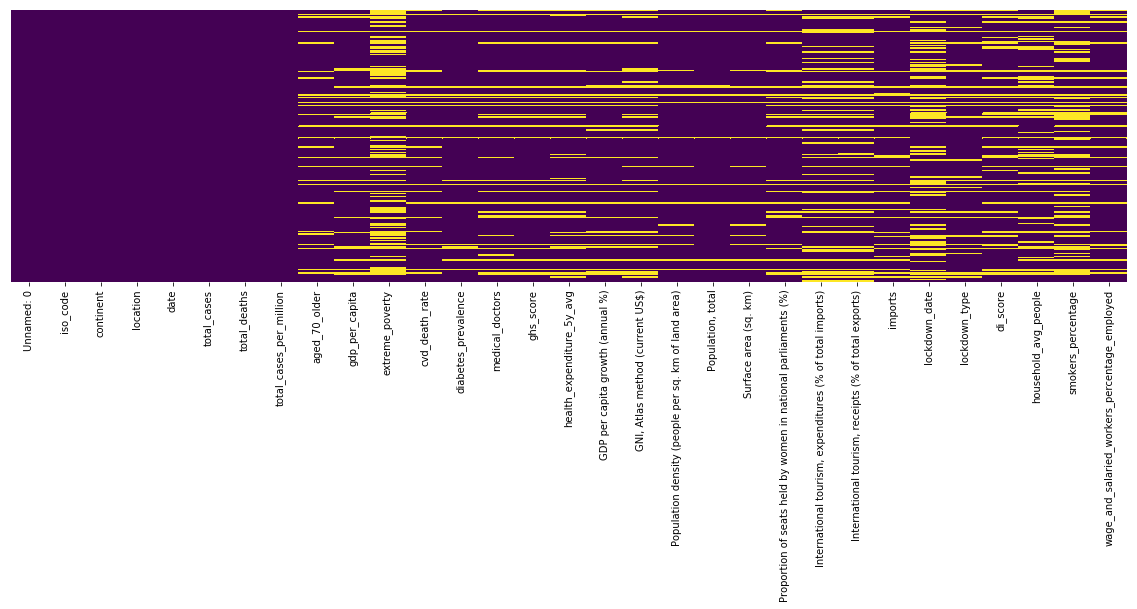

In [8]:
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

In [9]:
# remove columns based on correlation + missing values
df.drop(['extreme_poverty', 'aged_70_older', 'di_score'], inplace=True, axis=1)

corr = df.corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Unnamed: 0,total_cases,total_deaths,total_cases_per_million,gdp_per_capita,cvd_death_rate,diabetes_prevalence,medical_doctors,ghs_score,health_expenditure_5y_avg,GDP per capita growth (annual %),"GNI, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, receipts (% of total exports)",imports,household_avg_people,smokers_percentage,wage_and_salaried_workers_percentage_employed
Unnamed: 0,1,0.049,0.017,-0.0062,-0.056,0.079,-0.0014,-0.087,-0.025,-0.042,-0.0042,0.018,0.021,-0.045,-0.029,-0.0015,-0.17,-0.047,0.0023,0.15,-0.057,0.0062
total_cases,0.049,1,0.93,0.2,0.16,-0.11,0.046,0.08,0.34,0.3,0.017,0.77,-0.027,0.31,0.59,-0.02,-0.017,-0.14,0.67,-0.15,0.013,0.15
total_deaths,0.017,0.93,1,0.17,0.18,-0.19,0.0011,0.11,0.41,0.38,-0.0022,0.77,-0.037,0.25,0.45,0.072,-0.042,-0.13,0.72,-0.2,0.014,0.17
total_cases_per_million,-0.0062,0.2,0.17,1,0.61,-0.27,0.13,0.29,0.19,0.093,-0.068,0.11,0.2,-0.046,0.047,0.013,0.21,-0.14,0.13,-0.31,0.023,0.37
gdp_per_capita,-0.056,0.16,0.18,0.61,1,-0.47,0.26,0.57,0.53,0.21,-0.082,0.2,0.29,-0.058,0.061,0.091,0.16,-0.15,0.32,-0.62,0.13,0.7
cvd_death_rate,0.079,-0.11,-0.19,-0.27,-0.47,1,0.016,-0.2,-0.42,-0.27,0.11,-0.16,-0.18,0.0093,0.0032,-0.26,0.0024,-0.0023,-0.24,0.38,0.21,-0.32
diabetes_prevalence,-0.0014,0.046,0.0011,0.13,0.26,0.016,1,0.072,-0.045,-0.18,-0.2,0.051,0.14,0.022,-0.044,-0.2,0.2,0.3,0.031,-0.042,0.094,0.37
medical_doctors,-0.087,0.08,0.11,0.29,0.57,-0.2,0.072,1,0.49,0.39,0.18,0.11,0.039,-0.066,0.058,0.27,0.1,-0.083,0.18,-0.63,0.48,0.68
ghs_score,-0.025,0.34,0.41,0.19,0.53,-0.42,-0.045,0.49,1,0.49,0.21,0.37,0.071,0.13,0.25,0.26,-0.025,-0.33,0.51,-0.62,0.26,0.54
health_expenditure_5y_avg,-0.042,0.3,0.38,0.093,0.21,-0.27,-0.18,0.39,0.49,1,-0.018,0.33,-0.055,-0.075,0.1,0.29,-0.051,-0.15,0.36,-0.43,0.19,0.34


In [10]:
# plot for total cases per million
corr = df.loc[:, ['total_cases_per_million', 'gdp_per_capita', 'ghs_score', 'Population density (people per sq. km of land area)','International tourism, expenditures (% of total imports)', 'household_avg_people', 'wage_and_salaried_workers_percentage_employed']].corr()

corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,total_cases_per_million,gdp_per_capita,ghs_score,Population density (people per sq. km of land area),"International tourism, expenditures (% of total imports)",household_avg_people,wage_and_salaried_workers_percentage_employed
total_cases_per_million,1,0.61,0.19,0.2,0.21,-0.31,0.37
gdp_per_capita,0.61,1,0.53,0.29,0.16,-0.62,0.7
ghs_score,0.19,0.53,1,0.071,-0.025,-0.62,0.54
Population density (people per sq. km of land area),0.2,0.29,0.071,1,0.033,-0.056,0.12
"International tourism, expenditures (% of total imports)",0.21,0.16,-0.025,0.033,1,-0.0056,0.053
household_avg_people,-0.31,-0.62,-0.62,-0.056,-0.0056,1,-0.66
wage_and_salaried_workers_percentage_employed,0.37,0.7,0.54,0.12,0.053,-0.66,1


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

def showMetricsForLinearRegression(dataframe, y_name, xs_name):
  columns = xs_name
  columns.append(y_name)
  dataframe = dataframe.loc[:, columns]
  dataframe.dropna(how='any',axis=0, inplace=True)
  print(dataframe.shape)
  X = dataframe.drop(y_name, axis=1)
  y = dataframe[y_name]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

  regressor = LinearRegression()
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_test)

  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [12]:
showMetricsForLinearRegression(df, "total_cases_per_million", ['gdp_per_capita'])

(182, 2)
Mean Absolute Error: 1535.3136874772126
Mean Squared Error: 16244495.15808177
Root Mean Squared Error: 4030.446024707659


In [13]:
showMetricsForLinearRegression(df, "total_cases_per_million", ['Population density (people per sq. km of land area)', 'International tourism, expenditures (% of total imports)', 'wage_and_salaried_workers_percentage_employed'])

(145, 4)
Mean Absolute Error: 2837.2069421205574
Mean Squared Error: 33422181.16587106
Root Mean Squared Error: 5781.192019460265


-> GDP hat vergleichbaren erklärenden Wert, wie die anderen Attribute. Das GDP liegt allerdings umfangreicher vor und ist nur ein Feature, sodass die anderen Spalten mit einem zu hohen Korrelationskoeffizienten entfernt werden.

In [14]:
df_orig2 = df.copy()
df.drop(["ghs_score", "household_avg_people", "wage_and_salaried_workers_percentage_employed"], axis=1, inplace=True)

In [15]:
total_deaths_per_million = 10**(-6) * df["total_deaths"] / df["Population, total"]
df.insert(loc=8, column='total_deaths_per_million', value=total_deaths_per_million)

print(df.shape)
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

(209, 26)


,Unnamed: 0,total_cases,total_deaths,total_cases_per_million,total_deaths_per_million,gdp_per_capita,cvd_death_rate,diabetes_prevalence,medical_doctors,health_expenditure_5y_avg,GDP per capita growth (annual %),"GNI, Atlas method (current US$)",Population density (people per sq. km of land area),"Population, total",Surface area (sq. km),Proportion of seats held by women in national parliaments (%),"International tourism, expenditures (% of total imports)","International tourism, receipts (% of total exports)",imports,smokers_percentage
Unnamed: 0,1,0.049,0.017,-0.0062,-0.066,-0.056,0.079,-0.0014,-0.087,-0.042,-0.0042,0.018,0.021,-0.045,-0.029,-0.0015,-0.17,-0.047,0.0023,-0.057
total_cases,0.049,1,0.93,0.2,0.26,0.16,-0.11,0.046,0.08,0.3,0.017,0.77,-0.027,0.31,0.59,-0.02,-0.017,-0.14,0.67,0.013
total_deaths,0.017,0.93,1,0.17,0.41,0.18,-0.19,0.0011,0.11,0.38,-0.0022,0.77,-0.037,0.25,0.45,0.072,-0.042,-0.13,0.72,0.014
total_cases_per_million,-0.0062,0.2,0.17,1,0.54,0.61,-0.27,0.13,0.29,0.093,-0.068,0.11,0.2,-0.046,0.047,0.013,0.21,-0.14,0.13,0.023
total_deaths_per_million,-0.066,0.26,0.41,0.54,1,0.38,-0.37,-0.12,0.35,0.38,-0.0046,0.27,-0.0062,-0.005,0.066,0.26,-0.067,-0.16,0.31,0.13
gdp_per_capita,-0.056,0.16,0.18,0.61,0.38,1,-0.47,0.26,0.57,0.21,-0.082,0.2,0.29,-0.058,0.061,0.091,0.16,-0.15,0.32,0.13
cvd_death_rate,0.079,-0.11,-0.19,-0.27,-0.37,-0.47,1,0.016,-0.2,-0.27,0.11,-0.16,-0.18,0.0093,0.0032,-0.26,0.0024,-0.0023,-0.24,0.21
diabetes_prevalence,-0.0014,0.046,0.0011,0.13,-0.12,0.26,0.016,1,0.072,-0.18,-0.2,0.051,0.14,0.022,-0.044,-0.2,0.2,0.3,0.031,0.094
medical_doctors,-0.087,0.08,0.11,0.29,0.35,0.57,-0.2,0.072,1,0.39,0.18,0.11,0.039,-0.066,0.058,0.27,0.1,-0.083,0.18,0.48
health_expenditure_5y_avg,-0.042,0.3,0.38,0.093,0.38,0.21,-0.27,-0.18,0.39,1,-0.018,0.33,-0.055,-0.075,0.1,0.29,-0.051,-0.15,0.36,0.19


In [16]:
# medical_doctors correlates with gdp, health_expenditure and smokers
df.drop("medical_doctors", axis=1, inplace=True)

(209, 25)


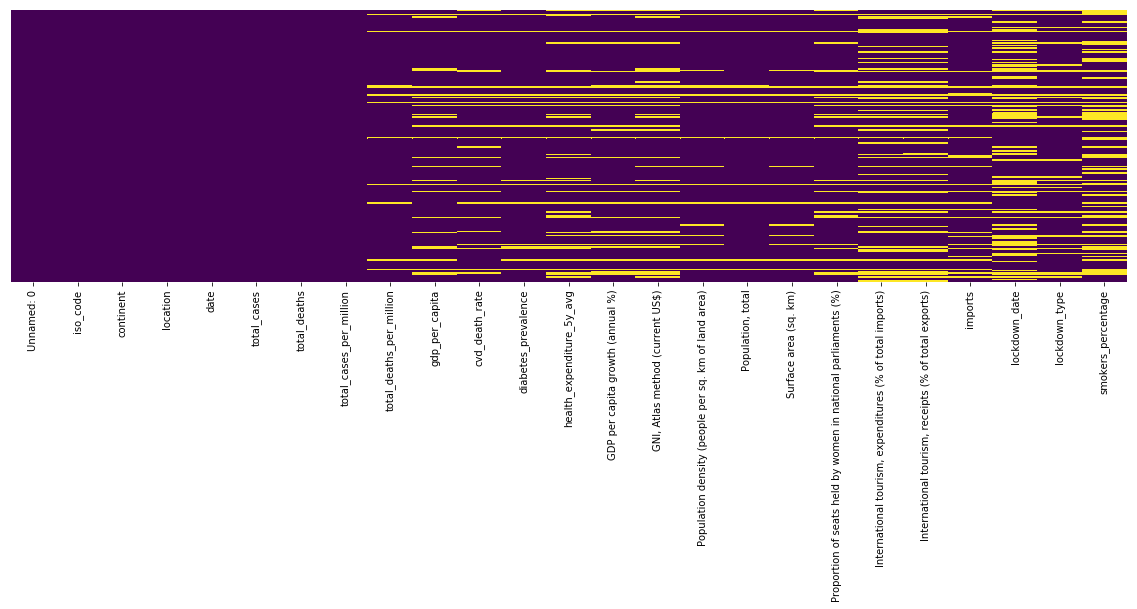

In [17]:
print(df.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)

In [18]:
# split into cases and deaths
df_cases = df.loc[:, ["total_cases", "total_cases_per_million", "gdp_per_capita", "health_expenditure_5y_avg",
                      "Population density (people per sq. km of land area)", "lockdown_type",
                      "International tourism, expenditures (% of total imports)"]]
df_deaths = df.loc[:, ["total_deaths", "total_deaths_per_million", "gdp_per_capita", "cvd_death_rate",
                       "health_expenditure_5y_avg", "smokers_percentage"]]

Cases
(209, 7)


,total_cases,total_cases_per_million,gdp_per_capita,health_expenditure_5y_avg,Population density (people per sq. km of land area),"International tourism, expenditures (% of total imports)"
total_cases,1,0.2,0.16,0.3,-0.027,-0.017
total_cases_per_million,0.2,1,0.61,0.093,0.2,0.21
gdp_per_capita,0.16,0.61,1,0.21,0.29,0.16
health_expenditure_5y_avg,0.3,0.093,0.21,1,-0.055,-0.051
Population density (people per sq. km of land area),-0.027,0.2,0.29,-0.055,1,0.033
"International tourism, expenditures (% of total imports)",-0.017,0.21,0.16,-0.051,0.033,1


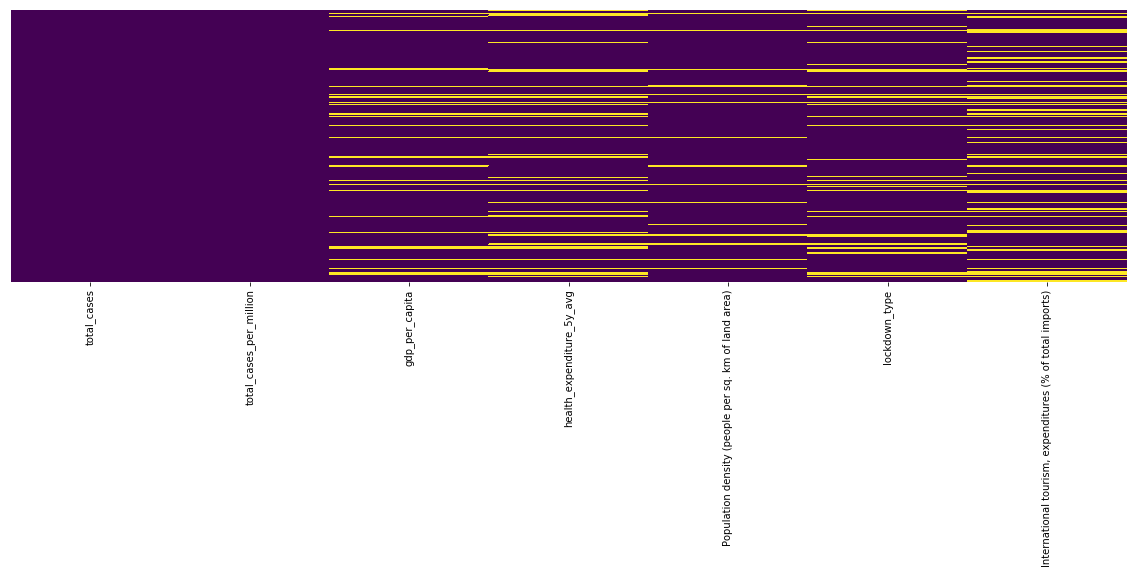

In [19]:
print("Cases")
print(df_cases.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_cases.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_cases.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,"International tourism, expenditures (% of total imports)","International tourism, expenditures (current US$)",imports,"GNI, PPP (current international $)"
"International tourism, expenditures (% of total imports)",1,0.059,-0.054,0.011
"International tourism, expenditures (current US$)",0.059,1,0.93,0.93
imports,-0.054,0.93,1,0.92
"GNI, PPP (current international $)",0.011,0.93,0.92,1


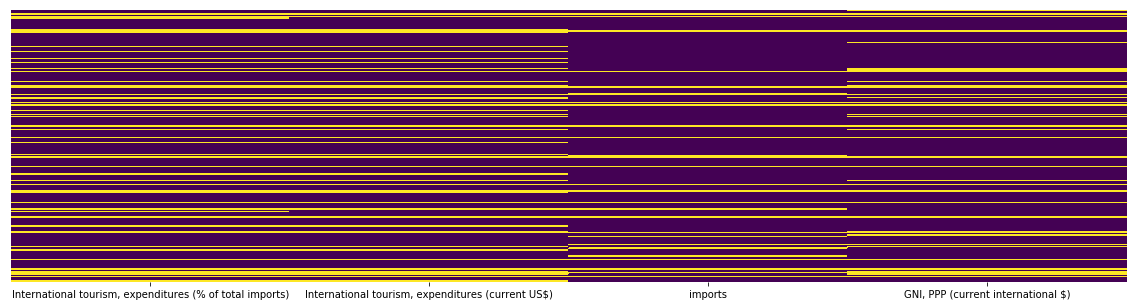

In [20]:
df_tourism = df_original.loc[:, ["International tourism, expenditures (% of total imports)",
                                 "International tourism, expenditures (current US$)",
                                 "imports",
                                 "GNI, PPP (current international $)"]]

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_tourism.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_tourism.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

(154, 2)
[8.22635242e+09 1.75506675e+09 1.76099010e+09 1.41145346e+09
 1.41922636e+09 2.33186685e+09 1.53405233e+09 1.68265282e+09
 1.58519983e+09 3.66528853e+09 2.40737684e+09 1.82566069e+09
 1.57352332e+09 1.75010462e+09 2.16076365e+09 1.92302437e+09
 1.62705917e+09 1.50103910e+09 1.87574594e+09]
19 values were added


,"International tourism, expenditures (% of total imports)","International tourism, expenditures (current US$)",imports,"GNI, PPP (current international $)",prediction
"International tourism, expenditures (% of total imports)",1,0.059,-0.054,0.011,1
"International tourism, expenditures (current US$)",0.059,1,0.93,0.93,0.058
imports,-0.054,0.93,1,0.92,-0.0052
"GNI, PPP (current international $)",0.011,0.93,0.92,1,0.047
prediction,1,0.058,-0.0052,0.047,1


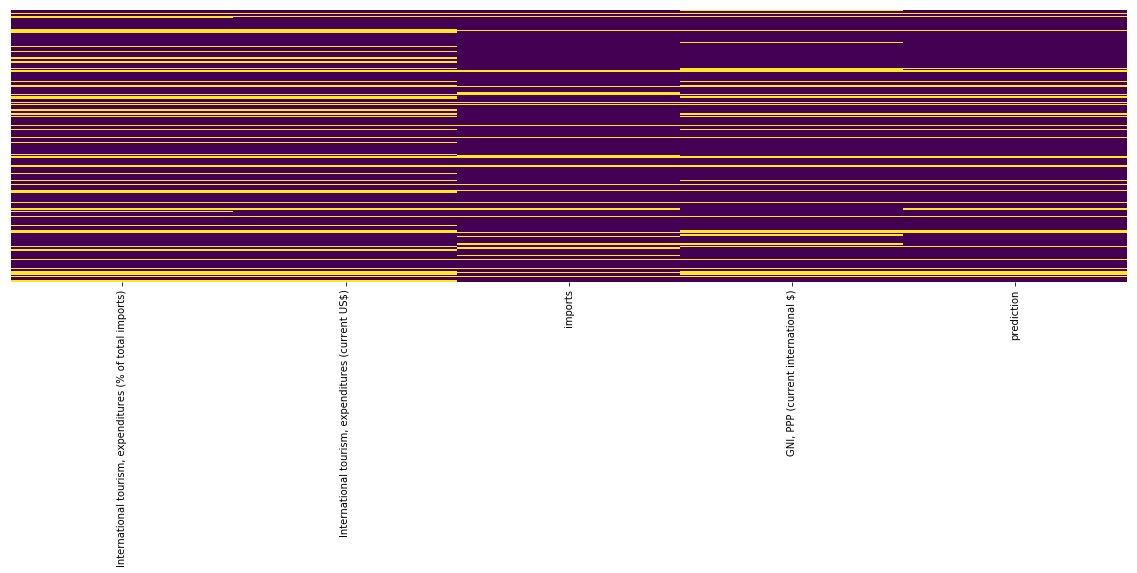

In [21]:
# predict expenditures (US$) based on GNI, calculate ratio
df_tourism_for_prediction = df_tourism.loc[:, ["International tourism, expenditures (current US$)",
                                              "GNI, PPP (current international $)"]].dropna()
print(df_tourism_for_prediction.shape)

X = df_tourism_for_prediction.drop("International tourism, expenditures (current US$)", axis=1)
y = df_tourism_for_prediction["International tourism, expenditures (current US$)"]

regressor = LinearRegression()
regressor.fit(X, y)

X_pred = pd.DataFrame(data={}, columns=['GNI, PPP (current international $)'])
i = 0
for index, row in df_tourism.iterrows():
  if (math.isnan(row["International tourism, expenditures (% of total imports)"])
    and not math.isnan(row["GNI, PPP (current international $)"])):
    X_pred.loc[i] = [row["GNI, PPP (current international $)"]]
    i-=-1

y_pred = regressor.predict(X_pred)
print(y_pred)

i=0
new_values = []
for index, row in df_tourism.iterrows():
  if (math.isnan(row["International tourism, expenditures (% of total imports)"])
    and not math.isnan(row["GNI, PPP (current international $)"])):
    new_values.append(y_pred[i] / row["imports"])
    i-=-1
  else:
    new_values.append(row["International tourism, expenditures (% of total imports)"])
df_tourism["prediction"] = new_values
print(i, "values were added")

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_tourism.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_tourism.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

Cases
(156, 7)


,total_cases,total_cases_per_million,gdp_per_capita,health_expenditure_5y_avg,Population density (people per sq. km of land area),"International tourism, expenditures (% of total imports)"
total_cases,1,0.2,0.16,0.3,-0.027,0.016
total_cases_per_million,0.2,1,0.61,0.093,0.2,0.23
gdp_per_capita,0.16,0.61,1,0.21,0.29,0.19
health_expenditure_5y_avg,0.3,0.093,0.21,1,-0.055,0.046
Population density (people per sq. km of land area),-0.027,0.2,0.29,-0.055,1,0.056
"International tourism, expenditures (% of total imports)",0.016,0.23,0.19,0.046,0.056,1


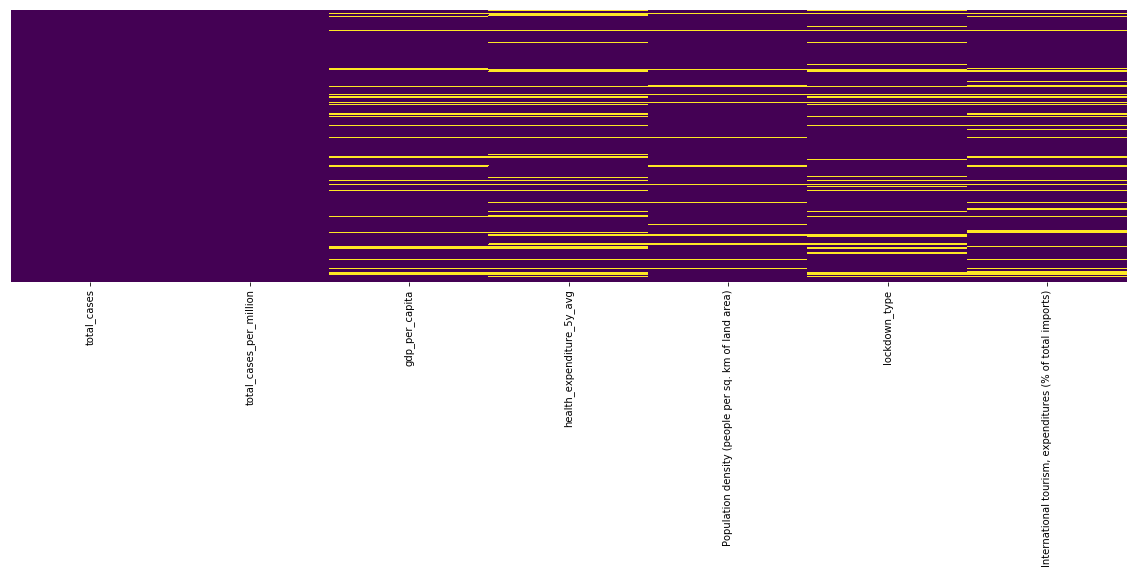

In [22]:
df_cases["International tourism, expenditures (% of total imports)"] = df_tourism["prediction"]

print("Cases")
print(df_cases.dropna().shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_cases.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_cases.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [23]:
df_cases["iso_code"] = df_original["iso_code"]
df_cases["location"] = df_original["location"]
df_cases.dropna().to_csv('cases.csv', sep=',', encoding='utf-8')

Deaths
(209, 6)


,total_deaths,total_deaths_per_million,gdp_per_capita,cvd_death_rate,health_expenditure_5y_avg,smokers_percentage
total_deaths,1,0.41,0.18,-0.19,0.38,0.014
total_deaths_per_million,0.41,1,0.38,-0.37,0.38,0.13
gdp_per_capita,0.18,0.38,1,-0.47,0.21,0.13
cvd_death_rate,-0.19,-0.37,-0.47,1,-0.27,0.21
health_expenditure_5y_avg,0.38,0.38,0.21,-0.27,1,0.19
smokers_percentage,0.014,0.13,0.13,0.21,0.19,1


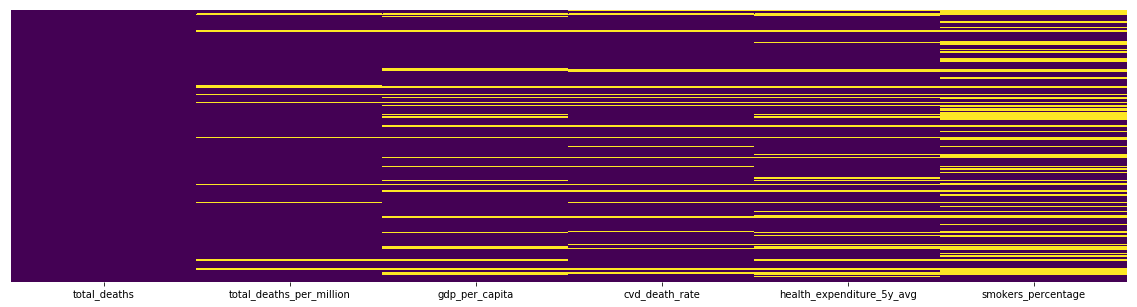

In [24]:
print("Deaths")
print(df_deaths.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_deaths.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_deaths.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

(209, 4)


,aged_70_older,medical_doctors,wage_and_salaried_workers_percentage_employed,smokers_percentage
aged_70_older,1,0.76,0.63,0.49
medical_doctors,0.76,1,0.68,0.48
wage_and_salaried_workers_percentage_employed,0.63,0.68,1,0.38
smokers_percentage,0.49,0.48,0.38,1


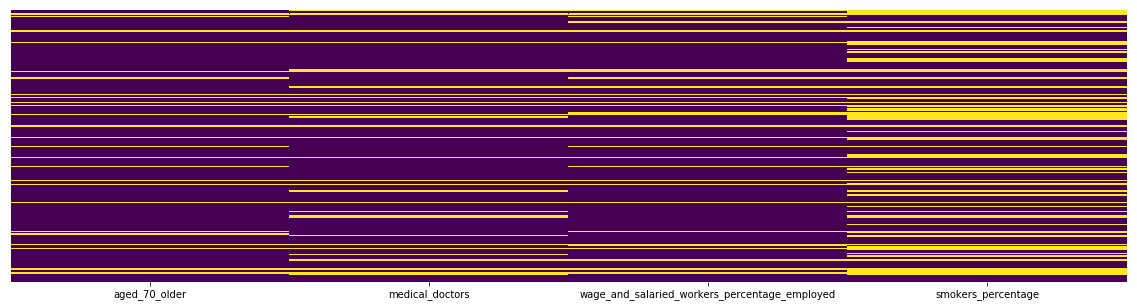

In [25]:
df_smokers = df_original.loc[:, ["aged_70_older", "medical_doctors"]]
df_smokers["wage_and_salaried_workers_percentage_employed"] = df_orig2["wage_and_salaried_workers_percentage_employed"]
df_smokers["smokers_percentage"] = df["smokers_percentage"]

print(df_smokers.shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_smokers.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_smokers.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

(134, 4)
[23.30724111 34.57790682 17.11135509 61.86329787 36.30166344 32.28413803
 18.37928539 31.62710717 29.57912823 26.21145402 60.09661066 19.70592316
 29.33870053 22.5635243  54.63182388 61.99041457 47.34568465 73.38170049
 78.49638069 81.36316687 59.95016285 21.08827056 70.1177006  42.64518663
 52.08010699 46.14337065 42.71690189 19.97189703 47.94021782 65.08336528
 17.70512081 54.20183042 70.65222663 67.74590443 58.68277662]


,aged_70_older,medical_doctors,wage_and_salaried_workers_percentage_employed,smokers_percentage
aged_70_older,1,0.76,0.63,0.1
medical_doctors,0.76,1,0.68,0.14
wage_and_salaried_workers_percentage_employed,0.63,0.68,1,0.26
smokers_percentage,0.1,0.14,0.26,1


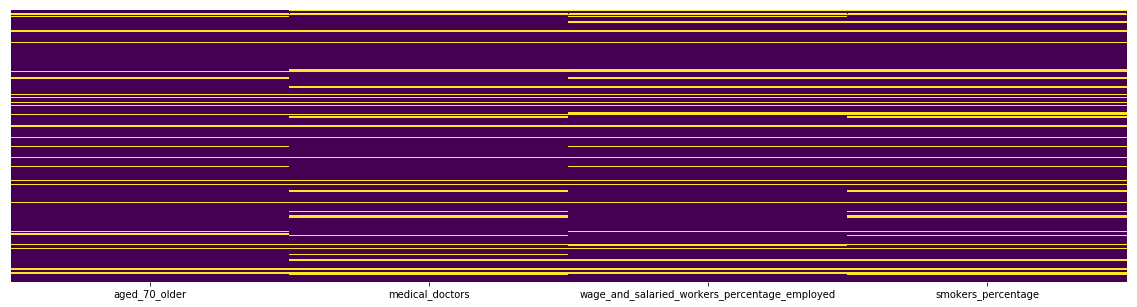

In [26]:
df_smokers_value_exists = df_smokers.dropna()
print(df_smokers_value_exists.shape)

X = df_smokers_value_exists.drop("smokers_percentage", axis=1)
y = df_smokers_value_exists["smokers_percentage"]

regressor = LinearRegression()
regressor.fit(X, y)

X_pred = pd.DataFrame(data={}, columns=['wage_and_salaried_workers_percentage_employed','aged_70_older','medical_doctors'])
i = 0
for index, row in df_smokers.iterrows():
  if (math.isnan(row["smokers_percentage"]) and not math.isnan(row["aged_70_older"])
    and not math.isnan(row["medical_doctors"]) and not math.isnan(row["wage_and_salaried_workers_percentage_employed"])):
    X_pred.loc[i] = [row["wage_and_salaried_workers_percentage_employed"], row["aged_70_older"], row["medical_doctors"]]
    i-=-1

y_pred = regressor.predict(X_pred)
print(y_pred)

i=0
for index, row in df_smokers.iterrows():
  if (math.isnan(row["smokers_percentage"]) and not math.isnan(row["aged_70_older"])
    and not math.isnan(row["medical_doctors"]) and not math.isnan(row["wage_and_salaried_workers_percentage_employed"])):
    row["smokers_percentage"] = y_pred[i]
    i-=-1

fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_smokers.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_smokers.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

(164, 6)


,total_deaths,total_deaths_per_million,gdp_per_capita,cvd_death_rate,health_expenditure_5y_avg,smokers_percentage
total_deaths,1,0.41,0.18,-0.19,0.38,-0.055
total_deaths_per_million,0.41,1,0.38,-0.37,0.38,-0.0079
gdp_per_capita,0.18,0.38,1,-0.47,0.21,-0.047
cvd_death_rate,-0.19,-0.37,-0.47,1,-0.27,0.11
health_expenditure_5y_avg,0.38,0.38,0.21,-0.27,1,-0.013
smokers_percentage,-0.055,-0.0079,-0.047,0.11,-0.013,1


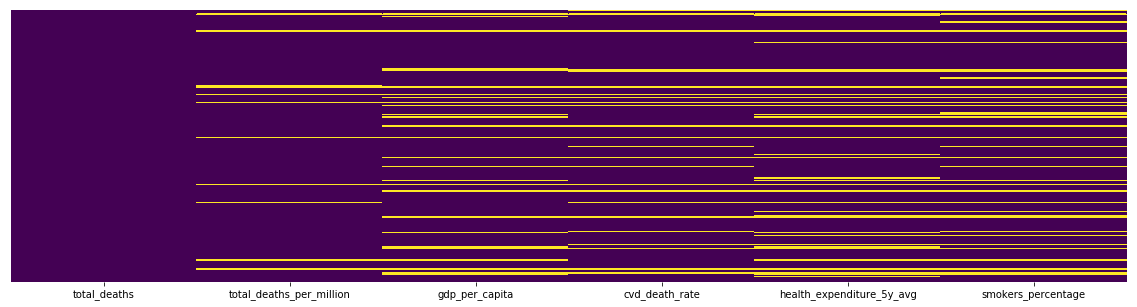

In [27]:
df_deaths["smokers_percentage"] = df_smokers["smokers_percentage"]

print(df_deaths.dropna().shape)
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(data = df_deaths.isnull(), yticklabels=False, cbar=False, cmap='viridis', ax=ax)
corr = df_deaths.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [28]:
df_deaths["iso_code"] = df_original["iso_code"]
df_deaths["location"] = df_original["location"]
df_deaths.dropna().to_csv('deaths.csv', sep=',', encoding='utf-8')